In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA

In [2]:
plt.style.use("ggplot")

In [ ]:
df = pd.read_csv("311-2014-2015.csv")

In [ ]:
cols = ['Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Status', 'Latitude', 'Longitude']
df = df[cols]

In [ ]:
nyc_facilities = pd.read_csv("NYCfac.txt",encoding = 'iso-8859-1')

In [ ]:
factype = pd.read_csv("Factype.txt",encoding = 'iso-8859-1')

In [ ]:
factype[factype['FT_Map'].str.contains("Fire")]

In [ ]:
#Police station = FacType 2001
#Fire House = FacType 2101

In [ ]:
pdfd = nyc_facilities[nyc_facilities['FacType'].isin([2001, 2101])]

In [ ]:
pdfd_cols = ['Borough','ZipCode', 'FacType','PolicePrct','XCoord', 'YCoord']
pdfd = pdfd[pdfd_cols]

In [ ]:
import pyproj

def convert(x, y):
    state_plane = pyproj.Proj(init='ESRI:102718', preserve_units=True)
    wgs = pyproj.Proj(proj='latlong', datum='WGS84', ellps='WGS84')
    lng, lat = pyproj.transform(state_plane, wgs, x, y)
    return lat, lng

In [ ]:
pdfd.head()

In [ ]:
def get_lat(row):
    x = row["XCoord"]
    y = row["YCoord"]
    lat, lon = convert(x, y)
    return lat

def get_lon(row):
    x = row["XCoord"]
    y = row["YCoord"]
    lat, lon = convert(x, y)
    return lon

In [ ]:
pdfd["Latitude"] = pdfd.apply(get_lat, axis=1)
pdfd["Longitude"] = pdfd.apply(get_lon, axis=1)

In [ ]:
#Police station = FacType 2001
#Fire House = FacType 2101
pdfd['Type'] = pdfd['FacType'].apply(lambda x: "Police" if x == 2001 else "Fire")

In [ ]:
pdfd.head()

In [ ]:
pdfd.to_csv("nypd-nyfd-stations.csv", index=False)

In [ ]:
df = df[df["Agency"] == "NYPD"]

In [ ]:
df.head()

In [ ]:
df["Closed Date"] = pd.to_datetime(df["Closed Date"], infer_datetime_format=True)

In [ ]:
df["Response Time Minutes"] = (df["Closed Date"] - df["Created Date"]) / np.timedelta64(1, 'm')

In [ ]:
df2 = df[df['Response Time Minutes'] > 0]

In [ ]:
df2['Response Time Minutes'].hist(range=(0, 350), bins=100, figsize=(14, 7))

In [ ]:
df2['Response Time Minutes'].median()

In [ ]:
nypd = pdfd[pdfd["Type"] == "Police"]

In [ ]:
from geopy.distance import vincenty

In [ ]:
nypd.head()

In [ ]:
from scipy import spatial
x, y = nypd.Latitude.values, nypd.Longitude.values
tree = spatial.KDTree(list(zip(x.ravel(), y.ravel())))
tree.data

In [ ]:
def closest_station(row):
    lat = row["Latitude"]
    lon = row["Longitude"]
    incident = (lat, lon)
    distances = []
    for i in range(len(nypd)):
        station = (nypd.ix[i].Latitude, nypd.ix[i].Longitude)
        distances.append(vincenty(incident, station).kilometers)
    #frame = nypd.ix[np.argmin(distances)][["Borough", "ZipCode", "PolicePrct"]]
    #frame["Distance Km"] = min(distances)
    #return frame
    return np.argmin(distances)

In [ ]:
def closest_tree_station(row):
    lat = row["Latitude"]
    lon = row["Longitude"]
    incident = (lat, lon)
    index = tree.query(incident)[1]
    station = (nypd.ix[index].Latitude, nypd.ix[index].Longitude)
    frame = nypd.ix[index][["Borough", "ZipCode", "PolicePrct"]]
    frame["Distance Km"] = vincenty(incident, station).kilometers
    return frame

In [ ]:
df2 = df2.dropna()

In [ ]:
import pygeohash as pgh

In [ ]:
def geohash(row):
    lat = row['Latitude']
    lon = row['Longitude']
    ghash = pgh.encode(lat, lon, precision=7)
    return ghash

In [ ]:
df2['geohash'] = df2.apply(geohash, axis=1)

In [ ]:
nypd['geohash'] = nypd.apply(geohash, axis=1)

In [ ]:
def approximate_closest(row):
    ghash = row["geohash"]
    incident = (lat, lon)
    distances = []
    for i in range(len(nypd)):
        station = nypd.ix[i].geohash
        distances.append(pgh.geohash_approximate_distance(ghash, station))
    frame = nypd.ix[np.argmin(distances)][["Borough", "ZipCode", "PolicePrct"]]
    frame["Distance Km"] = min(distances)
    return frame

In [ ]:
df2.head(10).apply(closest_tree_station, axis=1)

In [ ]:
df2 = pd.concat([df2, df2.apply(closest_tree_station, axis=1)], axis=1)

In [ ]:
df2.to_csv("df.csv", index=False)

In [3]:
df = pd.read_csv("df.csv", parse_dates=True)

In [4]:
df['Created Date'] = pd.to_datetime(df["Created Date"])

In [5]:
df["Complaint Hour"] = df["Created Date"].apply(lambda x: x.hour)
#The number of the day of the week with Monday=0, Sunday=6
df["Complaint Day"] = df["Created Date"].apply(lambda x: x.dayofweek)
df["Complaint Month"] = df["Created Date"].apply(lambda x: x.month)

In [93]:
def time_of_day(row):
    hour = row['Complaint Hour']
    if 6 < hour < 11:
        return "Morning"
    elif 11 < hour < 6:
        return "Day"
    else:
        return "Night"
    
def get_season(row):
    x = row["Complaint Month"]
    if x in [12, 1, 2]:
        return "Winter"
    elif x in [3, 4, 5]:
        return "Spring"
    elif x in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"
    
def same_zip(row):
    incident_zip = row['Incident Zip']
    police_zip = row['ZipCode']
    if incident_zip == police_zip:
        return 1
    else:
        return 0
    
def isweekend(row):
    day = row["Complaint Day"]
    if day >= 5:
        return 1
    else:
        return 0

In [96]:
df['isweekend'] = df.apply(isweekend, axis=1)
df['samezip'] = df.apply(same_zip, axis=1)
df['timeofday'] = df.apply(time_of_day, axis=1)

ValueError: ('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().', 'occurred at index 0')

In [98]:
df.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Status,Latitude,...,Borough,ZipCode,PolicePrct,Distance Km,Complaint Hour,Complaint Day,Complaint Month,isweekend,samezip,timeofday
0,2016-04-14 02:10:07,2016-04-14 03:17:04,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11221,Closed,40.695371,...,BK,11221,81,0.737484,2,3,4,0,1,Night
1,2016-04-14 02:08:10,2016-04-14 03:17:08,NYPD,New York City Police Department,Animal Abuse,Neglected,Residential Building/House,11221,Closed,40.695371,...,BK,11221,81,0.737484,2,3,4,0,1,Night
2,2016-04-14 01:55:06,2016-04-14 03:14:35,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11207,Closed,40.689359,...,BK,11237,83,1.090962,1,3,4,0,0,Night
3,2016-04-14 01:54:57,2016-04-14 02:09:44,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10013,Closed,40.716399,...,MN,10013,1,0.479000,1,3,4,0,1,Night
4,2016-04-14 01:47:52,2016-04-14 02:24:25,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Music,Street/Sidewalk,10009,Closed,40.725173,...,MN,10003,9,0.342959,1,3,4,0,0,Night


In [150]:
cols = ['Complaint Type', 'Location Type', 'Incident Zip', 'Borough',
        'PolicePrct', 'Distance Km', 'isweekend', 'samezip', 'timeofday','Complaint Month']
X = df[cols]
#features = pd.concat([X, pd.get_dummies(X["PolicePrct"])], axis=1)
features = pd.concat([X, pd.get_dummies(X["Location Type"])], axis=1)
features = pd.concat([X, pd.get_dummies(X["Complaint Type"])], axis=1)
features = pd.concat([features, pd.get_dummies(features['Incident Zip'])], axis=1)
#features = pd.concat([features, pd.get_dummies(features['Borough'])], axis=1)
features = pd.concat([features, pd.get_dummies(features['Complaint Month'])], axis=1)
del features["Incident Zip"]
#del features['PolicePrct']
del features['Complaint Month']
#del features['Borough']
del features['Location Type']
del features['Complaint Type']

In [151]:
features = pd.concat([features, pd.get_dummies(features['timeofday'])], axis=1)
del features['timeofday']

In [152]:
df2 = features

In [153]:
df2["responsetime"] = y

In [154]:
df2.to_csv("nypd_df.csv", index=False)

In [6]:
cols = ['Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip','Response Time Minutes', 'Borough',
       'ZipCode', 'PolicePrct', 'Distance Km', 'Complaint Hour',
       'Complaint Day', 'Complaint Month']
X = pd.get_dummies(df[cols])

In [109]:
y = df["Response Time Minutes"].round()

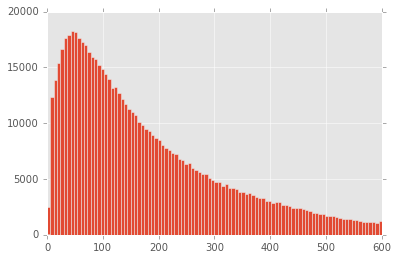

In [110]:
y.hist(range=(0, 600), bins=100)

In [32]:
features = pd.concat([X, pd.get_dummies(X["PolicePrct"])], axis=1)
features = pd.concat([features, pd.get_dummies(features['ZipCode'])], axis=1)
features = pd.concat([features, pd.get_dummies(features['Incident Zip'])], axis=1)
features = pd.concat([features, pd.get_dummies(features['Complaint Day'])], axis=1)
features = pd.concat([features, pd.get_dummies(features['Complaint Month'])], axis=1)
features = pd.concat([features, pd.get_dummies(features['Complaint Hour'])], axis=1)

In [33]:
del features['PolicePrct']
del features['ZipCode']

In [34]:
y = features["Response Time Minutes"].round()
del features["Response Time Minutes"]
del features["Incident Zip"]
del features['Complaint Day']
del features['Complaint Month']
del features['Complaint Hour']

In [44]:
y_med = y.median()
y_med_binary = y.apply(lambda x: 0 if x < y_med else 1)

In [142]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, y_med_binary, test_size=0.2, random_state=42)

In [149]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train[X_train.columns.values[feature_importances.argsort()[::-1][:4]]], y_train)
clf.score(X_test[X_test.columns.values[feature_importances.argsort()[::-1][:4]]], y_test)

0.55292124736816839

In [133]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.58334419213913902

In [134]:
feature_importances = clf.feature_importances_

In [135]:
feature_importances.argsort()[::-1][:10]

array([  0,   1,   2, 228, 235, 236, 238, 237, 239, 233])

In [125]:
X_train.columns.values

array(['Distance Km', 'isweekend', 'samezip', 'Animal Abuse',
       'Blocked Driveway', 'Derelict Vehicle', 'Disorderly Youth',
       'Drinking', 'Graffiti', 'Illegal Parking', 'Noise - Commercial',
       'Noise - House of Worship', 'Noise - Park', 'Noise - Residential',
       'Noise - Street/Sidewalk', 'Noise - Vehicle',
       'Non-Emergency Police Matter', 'Posting Advertisement', 'Traffic',
       'Vending', 83.0, 10000.0, 10001.0, 10002.0, 10003.0, 10004.0,
       10005.0, 10006.0, 10007.0, 10009.0, 10010.0, 10011.0, 10012.0,
       10013.0, 10014.0, 10016.0, 10017.0, 10018.0, 10019.0, 10020.0,
       10021.0, 10022.0, 10023.0, 10024.0, 10025.0, 10026.0, 10027.0,
       10028.0, 10029.0, 10030.0, 10031.0, 10032.0, 10033.0, 10034.0,
       10035.0, 10036.0, 10037.0, 10038.0, 10039.0, 10040.0, 10041.0,
       10044.0, 10048.0, 10065.0, 10069.0, 10075.0, 10103.0, 10107.0,
       10111.0, 10112.0, 10119.0, 10123.0, 10128.0, 10129.0, 10153.0,
       10154.0, 10162.0, 10280.0, 10281

In [136]:
X_train[X_train.columns.values[feature_importances.argsort()[::-1][:4]]].head()

,Distance Km,isweekend,samezip,MN
34684,1.771819,1,0,0
95321,1.854870,0,1,0
570245,0.747726,0,0,0
159522,0.514423,1,1,0
704689,0.275676,1,1,0


In [129]:
X_train.columns.values[clf.feature_importances_.argsort()[::-1][:4]]

array(['Distance Km', 'isweekend', 'MN', 'samezip'], dtype=object)

In [51]:
def selectKImportance(model, X, k=5):
     return X[:,model.feature_importances_.argsort()[::-1][:k]]
    
X_train2 = selectKImportance(clf,X_train,10)

TypeError: unhashable type: 'slice'

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha = 2)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)

In [ ]:
pca.explained_variance_ratio_

In [11]:
def same_zip(row):
    incident_zip = row['Incident Zip']
    police_zip = row['ZipCode']
    if incident_zip == police_zip:
        return 1
    else:
        return 0

In [13]:
X['Same Zip'] = X.apply(same_zip, axis=1)

In [84]:
def time_of_day(row):
    hour = row['Complaint Hour']
    if 6 < hour < 11:
        return "Morning"
    elif 11 < hour < 6:
        return "Day"
    else:
        return "Night"
    
def get_season(x):
    if x in [12, 1, 2]:
        return "Winter"
    elif x in [3, 4, 5]:
        return "Spring"
    elif x in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

In [82]:
X["Time of Day"] = X.apply(time_of_day, axis=1)

In [89]:
X["Season"] = X["Complaint Month"].apply(lambda x: get_season(x))

In [129]:
X2 = X.copy()

In [102]:
columns = ['Distance Km', 'Complaint Day',
           'Borough_BK', 'Borough_BX', 'Borough_MN',
       'Borough_QN', 'Borough_SI', 'Same Zip', 'Season', 'Time of Day']
features2 = X[columns]

In [103]:
features2 = pd.concat([features2, pd.get_dummies(features2['Complaint Day'])], axis=1)
features2 = pd.concat([features2, pd.get_dummies(features2['Season'])], axis=1)
features2 = pd.concat([features2, pd.get_dummies(features2['Time of Day'])], axis=1)
del features2['Complaint Day']
del features2['Time of Day']
del features2['Season']

In [109]:
from sklearn.preprocessing import StandardScaler
y = StandardScaler().fit_transform(y)

/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [121]:
X_train, X_test, y_train, y_test = train_test_split(features2, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X_train)
pca.explained_variance_ratio_

array([ 0.69418455,  0.16116342,  0.05836015,  0.0126753 ,  0.00667824,
        0.00495884,  0.00418881,  0.0031003 ,  0.0028053 ,  0.00235831,
        0.00220779,  0.0020806 ,  0.00205576,  0.00194874,  0.00184733,
        0.00182321,  0.00178255,  0.00143249,  0.001387  ,  0.00131402])

In [26]:
X_trainr = pca.transform(X_train)
X_testr = pca.transform(X_test)
features2_r = pca.fit(features2).transform(features2)

In [112]:
clf = linear_model.Lasso(alpha = .1)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

-8.948010358222902e-06

In [32]:
features2_r[:1000].shape

(1000, 20)

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
# Estimate the score on the entire dataset, with no missing values
estimator = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
score = cross_val_score(estimator, features2[:1000], y[:1000]).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -1.80


In [106]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create the dataset
rng = np.random.RandomState(1)
X_sample = features2[:5000]
y_sample = y[:5000]

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

regr_1.fit(X_sample, y_sample)
regr_2.fit(X_sample, y_sample)

# Predict
print(regr_1.score(X_sample, y_sample))
print(regr_2.score(X_sample, y_sample))

0.101983297868
-0.26518975433


In [120]:
features2.shape

(729053, 20)

MSE: 0.5062


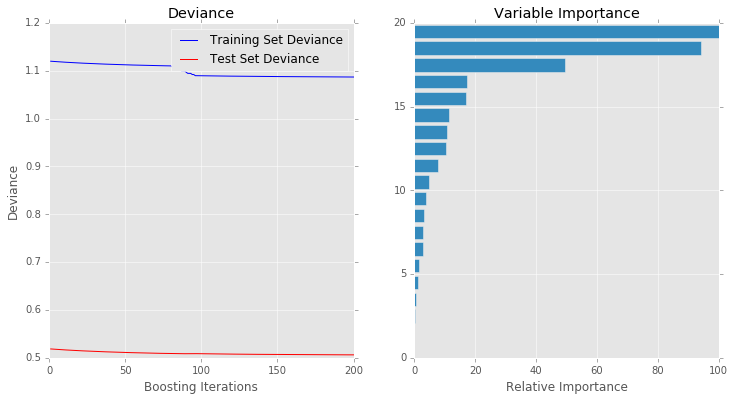

In [122]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

###############################################################################
# Load data
"""
offset1 = 30000
offset2 = 34000
X_train, y_train = features2[:offset1], y[:offset1]
X_test, y_test = features2[offset1:offset2], y[offset1:offset2]
"""
###############################################################################
# Fit regression model
params = {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
#plt.yticks(pos, features2.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

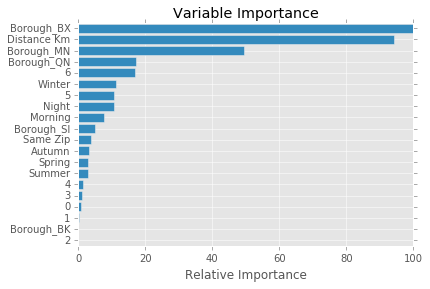

In [123]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features2.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/randomized_l1.py:609: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for k in range(n_resampling))
/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/randomized_l1.py:515: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 729053 but corresponding boolean dimension is 1000
  y = y[mask]
/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/randomized_l1.py:609: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for k in range(n_resampling))
/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/randomized_l1.py:515: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 729053 but corresponding boolean dimension is 1000
  y = y[mask]
/U

ValueError: Found arrays with inconsistent numbers of samples: [  1000 729053]

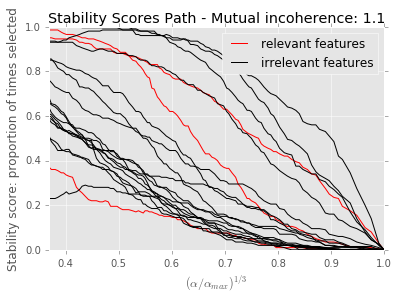

In [131]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn.linear_model import (RandomizedLasso, lasso_stability_path,
                                  LassoLarsCV)
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils.extmath import pinvh
from sklearn.utils import ConvergenceWarning


def mutual_incoherence(X_relevant, X_irelevant):
    """Mutual incoherence, as defined by formula (26a) of [Wainwright2006].
    """
    projector = np.dot(np.dot(X_irelevant.T, X_relevant),
                       pinvh(np.dot(X_relevant.T, X_relevant)))
    return np.max(np.abs(projector).sum(axis=1))


for conditioning in (1, 1e-4):
    ###########################################################################
    # Simulate regression data with a correlated design
    n_features = 20
    n_relevant_features = 3
    noise_level = .2
    coef_min = .2
    # The Donoho-Tanner phase transition is around n_samples=25: below we
    # will completely fail to recover in the well-conditioned case
    n_samples = 1000
    block_size = n_relevant_features

    rng = np.random.RandomState(42)

    # The coefficients of our model
    coef = np.zeros(n_features)
    coef[:n_relevant_features] = coef_min + rng.rand(n_relevant_features)

    # The correlation of our design: variables correlated by blocs of 3
    corr = np.zeros((n_features, n_features))
    for i in range(0, n_features, block_size):
        corr[i:i + block_size, i:i + block_size] = 1 - conditioning
    corr.flat[::n_features + 1] = 1
    corr = linalg.cholesky(corr)

    # Our design
    X = X_train[:1000]
    X = np.dot(X, corr)
    # Keep [Wainwright2006] (26c) constant
    X[:n_relevant_features] /= np.abs(
        linalg.svdvals(X[:n_relevant_features])).max()
    X = StandardScaler().fit_transform(X.copy())

    # The output variable
    # We scale the added noise as a function of the average correlation
    # between the design and the output variable
    y[:1000] += noise_level * rng.normal(size=n_samples)
    mi = mutual_incoherence(X[:, :n_relevant_features],
                            X[:, n_relevant_features:])

    ###########################################################################
    # Plot stability selection path, using a high eps for early stopping
    # of the path, to save computation time
    alpha_grid, scores_path = lasso_stability_path(X, y, random_state=42,
                                                   eps=0.05)

    plt.figure()
    # We plot the path as a function of alpha/alpha_max to the power 1/3: the
    # power 1/3 scales the path less brutally than the log, and enables to
    # see the progression along the path
    hg = plt.plot(alpha_grid[1:] ** .333, scores_path[coef != 0].T[1:], 'r')
    hb = plt.plot(alpha_grid[1:] ** .333, scores_path[coef == 0].T[1:], 'k')
    ymin, ymax = plt.ylim()
    plt.xlabel(r'$(\alpha / \alpha_{max})^{1/3}$')
    plt.ylabel('Stability score: proportion of times selected')
    plt.title('Stability Scores Path - Mutual incoherence: %.1f' % mi)
    plt.axis('tight')
    plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
               loc='best')

    ###########################################################################
    # Plot the estimated stability scores for a given alpha

    # Use 6-fold cross-validation rather than the default 3-fold: it leads to
    # a better choice of alpha:
    # Stop the user warnings outputs- they are not necessary for the example
    # as it is specifically set up to be challenging.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        lars_cv = LassoLarsCV(cv=6).fit(X, y)

    # Run the RandomizedLasso: we use a paths going down to .1*alpha_max
    # to avoid exploring the regime in which very noisy variables enter
    # the model
    alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6)
    clf = RandomizedLasso(alpha=alphas, random_state=42).fit(X, y)
    trees = ExtraTreesRegressor(100).fit(X, y)
    # Compare with F-score
    F, _ = f_regression(X, y)

    plt.figure()
    for name, score in [('F-test', F),
                        ('Stability selection', clf.scores_),
                        ('Lasso coefs', np.abs(lars_cv.coef_)),
                        ('Trees', trees.feature_importances_),
                        ]:
        precision, recall, thresholds = precision_recall_curve(coef != 0,
                                                               score)
        plt.semilogy(np.maximum(score / np.max(score), 1e-4),
                     label="%s. AUC: %.3f" % (name, auc(recall, precision)))

    plt.plot(np.where(coef != 0)[0], [2e-4] * n_relevant_features, 'mo',
             label="Ground truth")
    plt.xlabel("Features")
    plt.ylabel("Score")
    # Plot only the 100 first coefficients
    plt.xlim(0, 100)
    plt.legend(loc='best')
    plt.title('Feature selection scores - Mutual incoherence: %.1f'
              % mi)

plt.show()

In [136]:
scores_path

array([[ 0.985,  0.985,  0.985, ...,  0.01 ,  0.005,  0.   ],
       [ 0.95 ,  0.95 ,  0.95 , ...,  0.08 ,  0.03 ,  0.   ],
       [ 0.37 ,  0.37 ,  0.36 , ...,  0.   ,  0.   ,  0.   ],
       ..., 
       [ 0.51 ,  0.51 ,  0.485, ...,  0.   ,  0.   ,  0.   ],
       [ 0.76 ,  0.76 ,  0.75 , ...,  0.02 ,  0.01 ,  0.   ],
       [ 0.23 ,  0.23 ,  0.23 , ...,  0.015,  0.   ,  0.   ]])